In [18]:
# Create a plot showing the request with the time window
function plot_Request_Time_Window(passengers)
    figure();
    request_no = length(passengers)
    drop_time_list = []

    for i=1:request_no
        p = passengers[i]
        drop_time = p.pickup_time+p.duration
        push!(drop_time_list, drop_time)
        
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        hlines(y=i, xmin=p.pickup_time, xmax=drop_time, color=color_val)
        plot(p.pickup_time, i, marker="o", color=color_val)
        plot(drop_time, i, marker="o", color=color_val)
        
        time_stamp = string("T = ", p.pickup_time)
        text(p.pickup_time, i + 0.1, time_stamp, fontsize=8)
        time_stamp = string("T = ", drop_time)
        text(drop_time, i - 0.2, time_stamp, fontsize=8) 
    end

    PyPlot.yticks(1:request_no)
    ax = gca()
    ax[:set_xlim](passengers[1].pickup_time - 10, maximum(drop_time_list) + 20)
    ax[:set_ylim]([0, request_no + 1])
    title("Request vs Time")
    xlabel("Time")
    ylabel("Request #")
    grid("on")
end

plot_Request_Time_Window (generic function with 1 method)

In [19]:
using PyPlot
WIDTH = 51 # odd number
HEIGHT = 41 # odd number
NRG = min(WIDTH, HEIGHT)

type Passenger
    pickup_pos::Tuple{Int64, Int64}
    pickup_time::Int
    dropoff_pos::Tuple{Int64, Int64}
    duration::Int
end
type Driver
    cur_pos::Tuple{Int64, Int64}
end

function manhattan_distance(a, b)
    return sum(abs.([i for i in a]-[i for i in b]))
end

function rand_xy()
   return (rand(1:WIDTH), rand(1:HEIGHT)) 
end


function rand_normalized_xy()
    pass_x = Int(round((randn()/6+0.5)*(NRG-1)+1))
    pass_y = Int(round((randn()/6+0.5)*(NRG-1)+1))
    if WIDTH > HEIGHT
        pass_x += Int(round((WIDTH-HEIGHT)/2))
    else
        pass_y += Int(round((HEIGHT-WIDTH)/2))
    end
    return (pass_x, pass_y)
end


rand_normalized_xy (generic function with 1 method)

In [20]:
function plot_passenger_driver(passengers, drivers)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[] # driver current position x
    dys = Int64[] # driver current position y
    fig = figure("pyplot_scatterplot",figsize=(15,15) )#(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(passengers)
        p = passengers[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.3)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.3)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(drivers)
        d = drivers[i]
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="r")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="g")
    scatter(dxs,dys,s=300,alpha=0.5,color="b")
    
    title("Map")
    xlabel("X");xlim([1,WIDTH])
    ylabel("Y");ylim([1,HEIGHT])
    grid("on")
end


plot_passenger_driver (generic function with 1 method)

In [21]:
function genGrid(n_passenger, n_driver)
    passengers = Passenger[]
    drivers = Driver[]
    ptime = sort(rand(50:200,n_passenger))
    for i=1:n_passenger
        ppos = rand_xy()
        dpos = rand_xy()
        p = Passenger(ppos, ptime[i], dpos, manhattan_distance(ppos,dpos))
        push!(passengers, p)
    end
    for i=1:n_driver
        d = Driver((Int((WIDTH+1)/2), Int((HEIGHT+1)/2)))
        push!(drivers, d)
    end
    plot_passenger_driver(passengers, drivers)
    for p in passengers
        println(p)
    end
    plot_Request_Time_Window(passengers)
    return passengers,drivers
end

genGrid (generic function with 1 method)

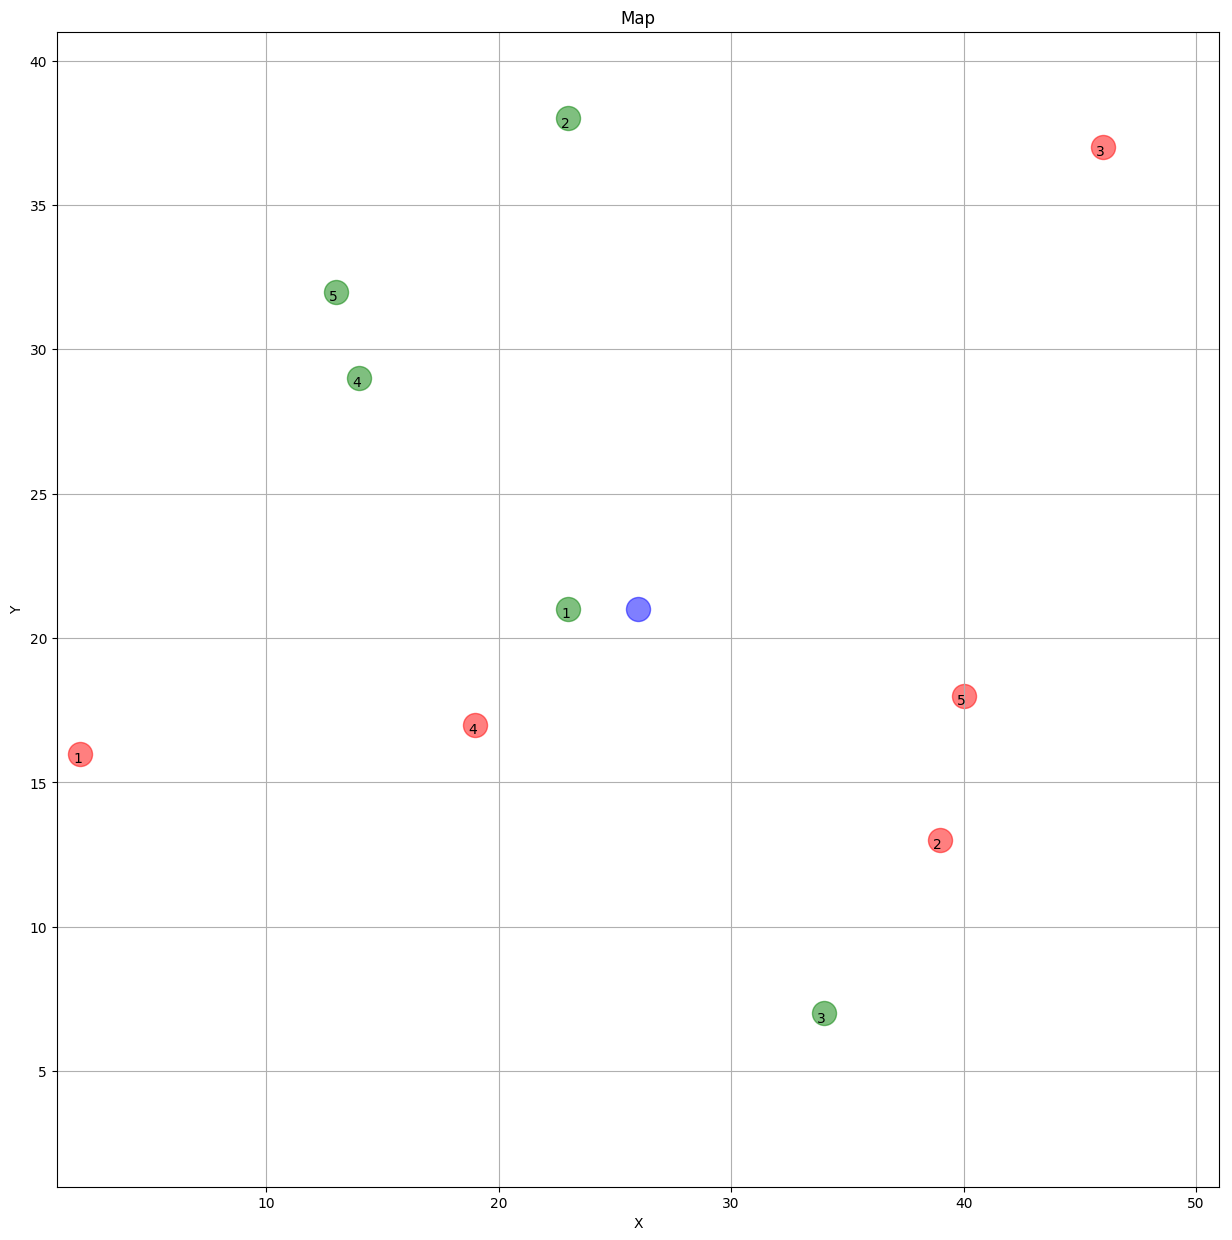

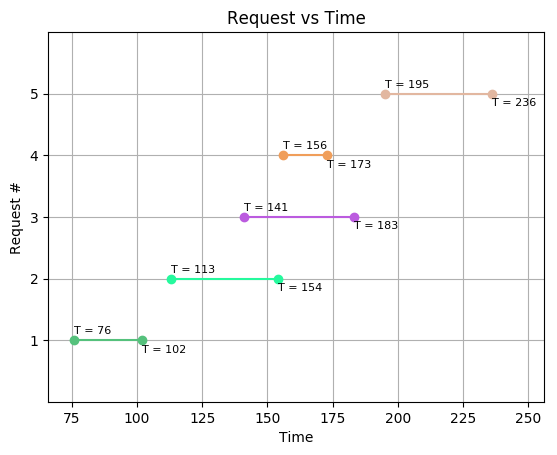

Passenger((2, 16), 76, (23, 21), 26)
Passenger((39, 13), 113, (23, 38), 41)
Passenger((46, 37), 141, (34, 7), 42)
Passenger((19, 17), 156, (14, 29), 17)
Passenger((40, 18), 195, (13, 32), 41)


(Passenger[Passenger((2, 16), 76, (23, 21), 26), Passenger((39, 13), 113, (23, 38), 41), Passenger((46, 37), 141, (34, 7), 42), Passenger((19, 17), 156, (14, 29), 17), Passenger((40, 18), 195, (13, 32), 41)], Driver[Driver((26, 21))])

In [22]:
requests, depot = genGrid(5,1)

In [23]:
# Get the coordinates of all pickup, drop and depot locations
print(depot)
nodes = []
for d in depot
    depot_node = d.cur_pos
    push!(nodes, depot_node)
end

for r in requests
    push!(nodes, r.pickup_pos)
    push!(nodes, r.dropoff_pos)
end
nodes

Driver[Driver((26, 21))]

11-element Array{Any,1}:
 (26, 21)
 (2, 16) 
 (23, 21)
 (39, 13)
 (23, 38)
 (46, 37)
 (34, 7) 
 (19, 17)
 (14, 29)
 (40, 18)
 (13, 32)

# Generating distance matrix 

In [24]:
# Generating distance matrix.

# Creating names for nodes
numReq = length(requests)
points = []
i = 0
push!(points,"Depot")
for r in 1:numReq
    i = i+1
    pickup = string("P_",i)
    drop = string("D_",i)
    push!(points,pickup)
    push!(points,drop)
end
println(points)

# Compute distance matrix for the Agencies
pointA = nodes
pointB = copy(nodes)

nodeLen = length(nodes) # nodes include pickup, dropoff and depot

D = zeros(nodeLen,nodeLen)

for j = 1:nodeLen
        for i = 1:nodeLen
            D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
        end
end
#println("Distance matrix : ",D)
println("")

using NamedArrays
dist_matrix =  NamedArray(D,(points,points),("From","To"))
show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)
points

Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3", "P_4", "D_4", "P_5", "D_5"]

11×11 Named Array{Float64,2}
From ╲ To │ Depot    P_1    D_1    P_2    D_2    P_3    D_3    P_4    D_4    P_5    D_5
──────────┼────────────────────────────────────────────────────────────────────────────
Depot     │   0.0   29.0    3.0   21.0   20.0   36.0   22.0   11.0   20.0   17.0   24.0
P_1       │  29.0    0.0   26.0   40.0   43.0   65.0   41.0   18.0   25.0   40.0   27.0
D_1       │   3.0   26.0    0.0   24.0   17.0   39.0   25.0    8.0   17.0   20.0   21.0
P_2       │  21.0   40.0   24.0    0.0   41.0   31.0   11.0   24.0   41.0    6.0   45.0
D_2       │  20.0   43.0   17.0   41.0    0.0   24.0   42.0   25.0   18.0   37.0   16.0
P_3       │  36.0   65.0   39.0   31.0   24.0    0.0   42.0   47.0   40.0   25.0   38.0
D_3       │  22.0   41.0   25.0   11.0   42.0   42.0    0.0   25.0   42.0   17.0   46.0
P_4       │  11.0   18.0    8.0   24.0   25.0   47.0   25.0    0.0   17.0   22.0   21.0
D_4    

11-element Array{Any,1}:
 "Depot"
 "P_1"  
 "D_1"  
 "P_2"  
 "D_2"  
 "P_3"  
 "D_3"  
 "P_4"  
 "D_4"  
 "P_5"  
 "D_5"  

# Dummy Problem

In [41]:
vehicle = [:Cab1 :Cab2]

1×2 Array{Symbol,2}:
 :Cab1  :Cab2

In [42]:
request = [:R1 :R2]
points = ["Depot"; "P1"; "D1"; "P2"; "D2"]
pickup = [(1,9) (4,8)]
drop = [(8,8) (2,10)]

pointA = [(0,0) (1,9) (8,8) (4,8) (2,10)]
pointB = copy(pointA)

D = zeros(5,5)
for j = 1:5
        for i = 1:5
            D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
        end
end

#Distance matrix can be used as time matrix also
using NamedArrays
dist_matrix =  NamedArray(D,(points,points),("From","To"))
show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)


5×5 Named Array{Float64,2}
From ╲ To │ Depot     P1     D1     P2     D2
──────────┼──────────────────────────────────
Depot     │   0.0   10.0   16.0   12.0   12.0
P1        │  10.0    0.0    8.0    4.0    2.0
D1        │  16.0    8.0    0.0    4.0    8.0
P2        │  12.0    4.0    4.0    0.0    4.0
D2        │  12.0    2.0    8.0    4.0    0.0

In [43]:
dist_matrix["P1","P2"]

4.0

In [44]:
# Time for 2 requests
pickup_time = [40 50]

# Calculate duration using distance matrix OR already done using Passenger info
duration = [8 4]
drop = [48 54]

avail = [1 1
         1 1 ] # availability of car1 car2 for req1, req2

2×2 Array{Int64,2}:
 1  1
 1  1

In [60]:
# Solving this version
using JuMP, Cbc
m = Model(solver = CbcSolver())

@variable(m, x[request,vehicle], Bin)   #Binary variable showing request served by vehicle
@constraint(m, c1[i in request], sum(x[i,j] for j in vehicle) == 1) # Each request is served once.
@objective(m, Min, sum(x[i,j] for i in request, j in vehicle))

println(m)
solve(m)

println(getvalue(x))


Min x[R1,Cab1] + x[R1,Cab2] + x[R2,Cab1] + x[R2,Cab2]
Subject to
 x[R1,Cab1] + x[R1,Cab2] == 1
 x[R2,Cab1] + x[R2,Cab2] == 1
 x[i,j] in {0,1} for all i in {R1,R2}, j in {Cab1,Cab2}

x: 2 dimensions:
[R1,:]
  [R1,Cab1] = 1.0
  [R1,Cab2] = 0.0
[R2,:]
  [R2,Cab1] = 1.0
  [R2,Cab2] = 0.0
